# Modeling

In [1]:
import pandas as pd
import numpy as np
import random
import datetime
from datetime import timedelta

#### Import data

In [2]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\flagship'

In [3]:
toy_dataset_df = pd.read_csv('toy_dataset_1_10_23.csv')
toy_products_df = pd.read_csv('toy_products_1_10_23.csv')

print(toy_products_df.shape)
print(toy_dataset_df.shape)

(3125, 6)
(32151, 23)


#### Clean data

In [4]:
toy_dataset_df['timestamp'] = pd.to_datetime(toy_dataset_df['timestamp'])

In [5]:
# Filter to only 'Online Store'
toy_dataset_df = toy_dataset_df[toy_dataset_df['point_of_sales']=='Online Store']

In [6]:
toy_dataset_df.shape

(29338, 23)

In [7]:
# Add column for transaction number for each user
df_sorted = toy_dataset_df.sort_values('timestamp').groupby(['hash_customer', 'timestamp']).first().reset_index()
df_sorted['transaction_num'] = df_sorted.groupby('hash_customer', sort=False)['timestamp'].rank(method='dense')
# Merge the transaction number back into the original dataframe
toy_dataset_df = toy_dataset_df.merge(df_sorted[['hash_customer', 'timestamp', 'transaction_num']], 
                                      on=['hash_customer', 'timestamp'])

#### Create train, test data sets based on date split

In [8]:
# create title-gender field
toy_dataset_df.loc[:,'product_title_gender'] = toy_dataset_df['product_title'] + '-' + toy_dataset_df['product_gender']

In [57]:
# split_date = '2022-04-01' # choose a date to split the data - roughly 80/20 split
split_date = '2022-06-01' # choose a date to split the data - roughly 80/20 split
train = toy_dataset_df[toy_dataset_df['timestamp'] < split_date]
test = toy_dataset_df[toy_dataset_df['timestamp'] >= split_date]

In [58]:
test_dates = test['timestamp'].dt.date.unique().tolist()
print(len(test_dates))
train_dates = train['timestamp'].dt.date.unique().tolist()
print(len(train_dates))

169
955


In [59]:
# percent of data in training data set
round(train.shape[0] / toy_dataset_df.shape[0] * 100.0,2)

88.3

In [60]:
print(train.shape)
print(test.shape)

(25906, 25)
(3432, 25)


### Baseline Model - top 10 titles over previous week

In [61]:
def get_top10_title_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular product_titles sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby('product_title').size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['transaction_date'] = as_of_dt
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'prev_wk_cnt', 'transaction_date', 'pred_rank']
    return top10_last_wk_df

In [62]:
get_top10_title_preds(as_of_dt='2021-08-13')

,title_pred,prev_wk_cnt,transaction_date,pred_rank
4,Olympic Running,64,2021-08-13,1.0
2,Iron Running,31,2021-08-13,2.0
8,Vanguard Sandal,12,2021-08-13,3.0
0,Classic Sneaker,9,2021-08-13,4.0
1,Hustler Boot,9,2021-08-13,5.0
3,League Running,8,2021-08-13,6.0
5,Rogue Sneaker,8,2021-08-13,7.0
6,Scalar Sandal,4,2021-08-13,8.0
7,Stacked Hiking Boot,2,2021-08-13,9.0


In [63]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred','pred_rank']], 
                       left_on='product_title',
                       right_on='title_pred',
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,

In [64]:
assert full_eval_df.shape[0] == test.shape[0]

In [65]:
def print_eval_metrics(eval_df):
    pct_purchases_top10 = round(eval_df['pred_rank'].count() / eval_df.shape[0],2) * 100.0
    avg_rank = round(eval_df['pred_rank'].mean(),2)
    reciprocal_ranks = 1 / eval_df['pred_rank']
    mrr = round(np.mean(reciprocal_ranks),3)
    print(f'Percent of purchases ranked in top 10: {pct_purchases_top10}%')
    print(f'Average rank of purchases: {avg_rank}')
    print(f'Mean Reciprocal Rank: {mrr}')

In [66]:
print_eval_metrics(eval_df=full_eval_df)

Percent of purchases ranked in top 10: 94.0%
Average rank of purchases: 3.67
Mean Reciprocal Rank: 0.491


In [67]:
def calc_category_eval_metrics(eval_df, category_var):
    results = {category_var: [], 'num_purchases': [], 
               'pct_purchases_top10': [], 'avg_rank': [], 'mrr': []}
    categories = eval_df[category_var].unique()
    for category in categories:
        df_category = eval_df[eval_df[category_var] == category]
        num_purchases = df_category.shape[0]
        pct_purchases_top10 = round(df_category['pred_rank'].count() / df_category.shape[0],2) * 100.0
        avg_rank = round(df_category['pred_rank'].mean(),2)
        reciprocal_ranks = 1 / df_category['pred_rank']
        mrr = np.mean(reciprocal_ranks)
        results[category_var].append(category)
        results['num_purchases'].append(num_purchases)
        results['pct_purchases_top10'].append(pct_purchases_top10)
        results['avg_rank'].append(avg_rank)
        results['mrr'].append(mrr)
    return pd.DataFrame(results)

In [68]:
calc_category_eval_metrics(eval_df=full_eval_df, category_var= 'product_category')

,product_category,num_purchases,pct_purchases_top10,avg_rank,mrr
0,Running,2055,100.0,2.45,0.643800
1,Sandal,383,79.0,6.57,0.178646
2,Sneaker,351,89.0,6.88,0.167670
3,Boot,643,87.0,4.80,0.277778


In [69]:
calc_category_eval_metrics(eval_df=full_eval_df, category_var= 'product_gender')

,product_gender,num_purchases,pct_purchases_top10,avg_rank,mrr
0,Youth,147,100.0,1.02,0.989796
1,Men,975,95.0,4.30,0.372556
2,Women,2039,96.0,3.76,0.474152
3,Kids,154,100.0,1.03,0.987013
4,Unisex,117,43.0,4.56,0.334238


In [70]:
full_eval_df.loc[:,'trans_num_grp'] = np.where(full_eval_df['transaction_num']==1,'first_purch', 
                                               np.where(full_eval_df['transaction_num']==2,'second_purch', 
                                                        'after_second_purch'))

In [71]:
calc_category_eval_metrics(eval_df=full_eval_df, category_var= 'trans_num_grp')

,trans_num_grp,num_purchases,pct_purchases_top10,avg_rank,mrr
0,after_second_purch,1915,94.0,3.37,0.533517
1,second_purch,952,94.0,3.97,0.452436
2,first_purch,565,95.0,4.19,0.411288


### Baseline model - top 10 title-gender products over previous week

In [72]:
def get_top10_title_gender_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular title-gender products sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & 
                                  (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby(['product_title', 'product_gender']).size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'gender_pred', 'prev_wk_cnt', 'pred_rank']
    top10_last_wk_df['transaction_date'] = as_of_dt
    return top10_last_wk_df

In [73]:
get_top10_title_gender_preds(as_of_dt = '2022-08-13', prev_days=7, top_n=10)

,title_pred,gender_pred,prev_wk_cnt,pred_rank,transaction_date
13,Olympic Running,Women,26,1.0,2022-08-13
8,League Running,Women,16,2.0,2022-08-13
0,Bejeweled Boot,Unisex,15,3.0,2022-08-13
6,Iron Running,Women,15,4.0,2022-08-13
4,Hustler Boot,Women,12,5.0,2022-08-13
14,Olympic Running,Youth,8,6.0,2022-08-13
10,Marathon Running,Women,8,7.0,2022-08-13
21,Stacked Hiking Boot,Women,7,8.0,2022-08-13
17,Rogue Sneaker,Women,7,9.0,2022-08-13
5,Iron Running,Men,7,10.0,2022-08-13


In [74]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_gender_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred', 'gender_pred', 'pred_rank']], 
                       left_on=['product_title','product_gender'],
                       right_on=['title_pred', 'gender_pred'],
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,

In [75]:
assert full_eval_df.shape[0] == test.shape[0]

In [76]:
print_eval_metrics(eval_df=full_eval_df)

Percent of purchases ranked in top 10: 62.0%
Average rank of purchases: 4.25
Mean Reciprocal Rank: 0.438


<AxesSubplot:>

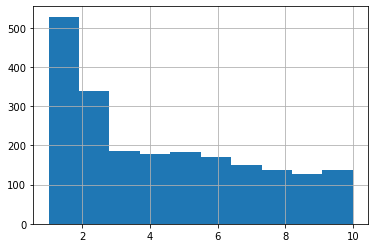

In [77]:
full_eval_df['pred_rank'].hist()

In [78]:
calc_category_eval_metrics(eval_df=full_eval_df, 
                            category_var = 'product_category')

,product_category,num_purchases,pct_purchases_top10,avg_rank,mrr
0,Running,2055,77.0,3.95,0.481304
1,Sandal,383,25.0,6.63,0.178434
2,Sneaker,351,26.0,7.30,0.177967
3,Boot,643,57.0,4.20,0.379647


In [79]:
calc_category_eval_metrics(eval_df=full_eval_df, 
                            category_var = 'product_gender')

,product_gender,num_purchases,pct_purchases_top10,avg_rank,mrr
0,Youth,147,54.0,6.54,0.183569
1,Men,975,41.0,6.26,0.222043
2,Women,2039,75.0,3.57,0.511266
3,Kids,154,58.0,5.76,0.233818
4,Unisex,117,32.0,2.21,0.760808


In [80]:
full_eval_df.loc[:,'trans_num_grp'] = np.where(full_eval_df['transaction_num']==1,'first_purch', 
                                               np.where(full_eval_df['transaction_num']==2,'second_purch', 
                                                        'after_second_purch'))

In [81]:
calc_category_eval_metrics(eval_df=full_eval_df, category_var= 'trans_num_grp')

,trans_num_grp,num_purchases,pct_purchases_top10,avg_rank,mrr
0,after_second_purch,1915,64.0,4.10,0.450185
1,second_purch,952,60.0,4.33,0.432453
2,first_purch,565,60.0,4.70,0.400115


### Collaborative Filtering

In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split

In [ ]:
# Define the Reader object
reader = Reader(rating_scale=(0, 1))

In [ ]:
cf_train_data_set = train.groupby(['hash_customer', 'product_title_gender']).size().reset_index(name='count')

In [ ]:
cf_train_data_set.head()

In [ ]:
# Load the data into the Surprise dataset format
data = Dataset.load_from_df(cf_train_data_set, reader)

In [ ]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

In [ ]:
# Define the algorithm
sim_options = {"name": "cosine", "user_based": False}
algo = KNNBasic(sim_options=sim_options)

In [ ]:
# Train the model on the training set
algo.fit(trainset)

In [ ]:
# Test the model on the test set
predictions = algo.test(testset)

In [ ]:
# Create a dictionary of items for each user
from collections import defaultdict
user_items = defaultdict(list)
for uid, iid, true_rating, est_rating, _ in predictions:
    user_items[uid].append((iid, est_rating))

# Sort the items for each user by their estimated rating
for uid, items in user_items.items():
    items.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 item recommendations for each user
top_n = {}
for uid, items in user_items.items():
    top_n[uid] = [iid for (iid, _) in items[:10]]

In [ ]:
top_n

In [ ]:
from surprise import SVD

In [ ]:
# Define the algorithm
algo = SVD(verbose=True, n_epochs=10)

# Train the model on the training set
algo.fit(trainset)

# Test the model on the test set
predictions = algo.test(testset)

In [ ]:
# from surprise.model_selection import cross_validate

In [ ]:
# cross_validate(algo, trainset, measures=['RMSE', 'MAE'], cv=3, verbose=True)

In [ ]:
# Create a dictionary of items for each user
from collections import defaultdict
user_items = defaultdict(list)
for uid, iid, true_rating, est_rating, _ in predictions:
    user_items[uid].append((iid, est_rating))

# Sort the items for each user by their estimated rating
for uid, items in user_items.items():
    items.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 item recommendations for each user
top_n = {}
for uid, items in user_items.items():
    top_n[uid] = [iid for (iid, _) in items[:10]]

In [ ]:
top_n

## Binary classifier

#### Create training data set

In [82]:
positive_samples = train[['timestamp', 'transaction_id', 'hash_customer', 
                          'sale_amount', 'product_title', 'product_color', 'product_gender',
                          'product_category', 'referrer_source', 'product_title_gender',
                         'transaction_num']].copy()

positive_samples.loc[:,'purchase'] = 1

In [83]:
genders = train['product_gender'].unique()
print(genders)

colors = train['product_color'].unique()
print(colors)

['Women' 'Men' 'Kids' 'Youth' 'Unisex']
['Midnight Green (Eagle Green)' 'Prussian Blue' 'Electric Purple'
 'Stormcloud' 'Vermilion (Plochere)' 'Topaz' 'Royal Blue (Web)'
 'Lavender Purple' 'Han Purple' 'Burnt Sienna' 'Green (Munsell)'
 'Dark Red' 'Electric Green' 'Fern Green' 'Ruby Red' 'Mikado Yellow'
 'Pastel Magenta' 'Canary Yellow' 'Dartmouth Green' 'Dark Powder Blue'
 'Alice Blue' 'Mordant Red 19' 'Sky Blue' 'Yellow-Green'
 'Selective Yellow']


In [84]:
def count_category_in_days(df, days, as_of_dt):
    """Function to return counts of occurrences in the previous n_days from as_of_dt """
    end_date = pd.to_datetime(as_of_dt)
    start_date = end_date - datetime.timedelta(days=days)
    filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
    return len(filtered_df)

In [85]:
hist_data = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime('2022-01-01'))]

In [86]:
def calc_user_features(df):
    """
    Function to calculate user features
    Returns dataframe
    """
    agg_df = df.groupby('hash_customer').agg({
        'product_title': ['count'],
        'sale_amount': ['mean']
    }).reset_index()

    agg_df.columns = ['hash_customer', 
                      'user_trans_cnt', 'user_avg_prod_cost']
    return agg_df

In [87]:
calc_user_features(df=hist_data).head()

,hash_customer,user_trans_cnt,user_avg_prod_cost
0,2785466729578054,3,198.000000
1,2943184540671871,6,197.666667
2,4042200167694193,5,194.000000
3,6606248094173010,1,198.000000
4,11352255998594515,2,196.000000


In [88]:
def calc_title_features(df):
    """
    Function to calculate features
    Returns dataframe
    """
    agg_df = df.groupby('product_title').agg({
        'product_title': ['count'],
    }).reset_index()

    agg_df.columns = ['product_title', 'title_tot_sales']
    return agg_df

In [89]:
calc_title_features(df=hist_data).head()

,product_title,title_tot_sales
0,Alley Boot,9
1,Classic Sneaker,1484
2,Corner Sandal,72
3,Evermore Boot,109
4,Gator Sandal,64


In [90]:
def calc_titgen_features(df):
    """
    Function to calculate title-gender features
    Returns dataframe
    """
    agg_df = df.groupby('product_title_gender').agg({
        'product_title': ['count'],
        'transaction_id': ['nunique'],
        'sale_amount': ['sum', 'mean']
    }).reset_index()

    agg_df.columns = ['product_title_gender', 'titgen_title_cnt',
                      'titgen_trans_cnt', 'titgen_tot_sales', 'titgen_avg_prod_cost']
    return agg_df

In [91]:
calc_titgen_features(df=hist_data).head()

,product_title_gender,titgen_title_cnt,titgen_trans_cnt,titgen_tot_sales,titgen_avg_prod_cost
0,Alley Boot-Men,9,9,1746.00,194.000000
1,Classic Sneaker-Men,413,377,62265.00,150.762712
2,Classic Sneaker-Women,1071,982,165433.91,154.466769
3,Corner Sandal-Unisex,72,61,22176.00,308.000000
4,Evermore Boot-Men,35,33,8412.00,240.342857


In [92]:
def calc_user_gen_features(df):
    """
    Function to calculate features
    Returns dataframe
    """
    agg_df = df.groupby(['hash_customer','product_gender']).agg({
        'product_title': ['count'],
        'sale_amount': ['mean']
    }).reset_index()

    agg_df.columns = ['hash_customer', 'product_gender',
                      'user_gen_trans_cnt', 'user_gen_avg_prod_cost']
    return agg_df

In [93]:
calc_user_gen_features(df=hist_data).head()

,hash_customer,product_gender,user_gen_trans_cnt,user_gen_avg_prod_cost
0,2785466729578054,Men,1,198.000000
1,2785466729578054,Women,2,198.000000
2,2943184540671871,Women,6,197.666667
3,4042200167694193,Men,1,194.000000
4,4042200167694193,Women,4,194.000000


In [94]:
def calc_user_cat_features(df):
    """
    Function to calculate features
    Returns dataframe
    """
    agg_df = df.groupby(['hash_customer','product_category']).agg({
        'product_title': ['count'],
        'sale_amount': ['mean']
    }).reset_index()

    agg_df.columns = ['hash_customer', 'product_category',
                      'user_cat_trans_cnt', 'user_cat_avg_prod_cost']
    return agg_df

In [95]:
calc_user_cat_features(df=hist_data).head()

,hash_customer,product_category,user_cat_trans_cnt,user_cat_avg_prod_cost
0,2785466729578054,Running,2,198.000000
1,2785466729578054,Sneaker,1,198.000000
2,2943184540671871,Running,3,196.666667
3,2943184540671871,Sandal,1,308.000000
4,2943184540671871,Sneaker,2,144.000000


In [96]:
def calc_category_features(as_of_dt):
    """
    Function to calculate features
    Returns dataframe
    """
    hist_data = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime(as_of_dt))]

    # Group by product title and apply the count_title_in_days function to calculate the counts for each title in the past 30, 60, and 90 days
    counts_df = hist_data.groupby('product_category') \
        .apply(lambda x: pd.Series({'cat_sales10': count_category_in_days(x, 10, as_of_dt), 
                                    'cat_sales30': count_category_in_days(x, 30, as_of_dt),
                                    'cat_sales90': count_category_in_days(x, 90, as_of_dt),
                                    'cat_sales_all': count_category_in_days(x, 1000, as_of_dt)})).reset_index()
    return counts_df

In [97]:
calc_category_features(as_of_dt='2021-03-26').head()

,product_category,cat_sales10,cat_sales30,cat_sales90,cat_sales_all
0,Boot,23,221,292,1173
1,Running,197,783,1384,5483
2,Sandal,20,144,188,390
3,Sneaker,45,231,393,1529


In [98]:
def calc_gen_features(as_of_dt):
    """
    Function to calculate features
    Returns dataframe
    """
    hist_data = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime(as_of_dt))]

    # Group by product title and apply the count_title_in_days function to calculate the counts for each title in the past 30, 60, and 90 days
    counts_df = hist_data.groupby('product_gender') \
        .apply(lambda x: pd.Series({'gen_sales10': count_category_in_days(x, 10, as_of_dt), 
                                    'gen_sales30': count_category_in_days(x, 30, as_of_dt),
                                    'gen_sales90': count_category_in_days(x, 90, as_of_dt),
                                    'gen_sales_all': count_category_in_days(x, 1000, as_of_dt)})).reset_index()
    return counts_df

In [99]:
calc_gen_features(as_of_dt='2022-03-26').head()

,product_gender,gen_sales10,gen_sales30,gen_sales90,gen_sales_all
0,Kids,13,71,125,888
1,Men,72,389,796,5695
2,Unisex,4,27,53,187
3,Women,197,1682,2802,16419
4,Youth,20,46,89,663


In [100]:
print(positive_samples.shape)
positive_samples = positive_samples[positive_samples['transaction_num']>1]
print(positive_samples.shape)

(25906, 12)
(15844, 12)


#### Loop over dates, calculate features, create training data set

In [101]:
%%time

NUM_DATES_TO_LOOP_OVER = 100
NUM_NEGATIVE_SAMPLES = 2

# order samples to loop over them backwards chronologically
positive_samples = positive_samples.sort_values('timestamp', ascending=False)

train_df = pd.DataFrame()

# loop through dates
for idx, dt, in enumerate(positive_samples['timestamp'].dt.date.unique()[0:NUM_DATES_TO_LOOP_OVER]):
    print(dt, end=',')
    
    # subset purchases by date
    purchases = positive_samples[positive_samples['timestamp'].dt.date == dt]
    
    all_negative_samples = pd.DataFrame()
    # loop over purchases
    for idx, row in purchases.iterrows():
        # create negative_samples
        dfs = [row.to_frame().T for i in range(NUM_NEGATIVE_SAMPLES)]
        negative_samples = pd.concat(dfs, ignore_index=True)
        negative_samples['purchase'] = 0
        negative_samples['product_gender'] = negative_samples['product_gender'].apply(lambda x: random.choice(genders))
        negative_samples['product_color'] = negative_samples['product_color'].apply(lambda x: random.choice(colors))
        # sale_amount, title, category
        sample_product = train[['sale_amount', 'product_title', 'product_category']].sample(NUM_NEGATIVE_SAMPLES)
        negative_samples['sale_amount'] = sample_product['sale_amount'].values
        negative_samples['product_title'] = sample_product['product_title'].values
        negative_samples['product_category'] = sample_product['product_category'].values
        negative_samples.loc[:,'product_title_gender'] = negative_samples['product_title'] + '-' + negative_samples['product_gender']
        all_negative_samples = pd.concat([all_negative_samples, negative_samples])
    
    daily_df = pd.concat([all_negative_samples, purchases])
    
    hist_data = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime(dt))]
    
    # add user features
    user_features_df = calc_user_features(df=hist_data)
    daily_train_df = pd.merge(left=daily_df, 
                            right=user_features_df,
                            left_on='hash_customer',
                            right_on='hash_customer', 
                            how='left')
    
    # add titgen features
    titgen_features_df = calc_titgen_features(df=hist_data)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=titgen_features_df,
                            left_on='product_title_gender',
                            right_on='product_title_gender', 
                            how='left')
    
    # add user-gen features
    user_gen_features_df = calc_user_gen_features(df=hist_data)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=user_gen_features_df,
                            left_on=['hash_customer', 'product_gender'],
                            right_on=['hash_customer', 'product_gender'], 
                            how='left')

    # add title features
    title_features_df = calc_title_features(df=hist_data)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=title_features_df,
                            left_on='product_title',
                            right_on='product_title', 
                            how='left')
    
    # add user-cat features
    user_cat_features_df = calc_user_cat_features(df=hist_data)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=user_cat_features_df,
                            left_on=['hash_customer', 'product_category'],
                            right_on=['hash_customer', 'product_category'], 
                            how='left')

    # add cat features
    cat_features_df = calc_category_features(as_of_dt=dt)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=cat_features_df,
                            left_on='product_category',
                            right_on='product_category', 
                            how='left')

    # gender
    gen_features_df = calc_gen_features(as_of_dt=dt)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=gen_features_df,
                            left_on='product_gender',
                            right_on='product_gender', 
                            how='left')

    # gender-cat features?
    
    train_df = pd.concat([train_df, daily_train_df])
    print(train_df.shape[0], end=',')

2022-05-31,51,2022-05-30,102,2022-05-29,156,2022-05-28,186,2022-05-27,225,2022-05-26,282,2022-05-25,408,2022-05-24,459,2022-05-23,540,2022-05-22,585,2022-05-21,621,2022-05-20,654,2022-05-19,690,2022-05-18,765,2022-05-17,831,2022-05-16,909,2022-05-15,933,2022-05-14,984,2022-05-13,1047,2022-05-12,1092,2022-05-11,1176,2022-05-10,1218,2022-05-09,1290,2022-05-08,1341,2022-05-07,1389,2022-05-06,1458,2022-05-05,1548,2022-05-04,1650,2022-05-03,1719,2022-05-02,1806,2022-05-01,1851,2022-04-30,1896,2022-04-29,1938,2022-04-28,1995,2022-04-27,2133,2022-04-26,2199,2022-04-25,2298,2022-04-24,2346,2022-04-23,2388,2022-04-22,2421,2022-04-21,2472,2022-04-20,2559,2022-04-19,2607,2022-04-18,2643,2022-04-17,2685,2022-04-16,2745,2022-04-15,2820,2022-04-14,2889,2022-04-13,3012,2022-04-12,3066,2022-04-11,3114,2022-04-10,3189,2022-04-09,3234,2022-04-08,3264,2022-04-07,3303,2022-04-06,3372,2022-04-05,3420,2022-04-04,3486,2022-04-03,3543,2022-04-02,3585,2022-04-01,3663,2022-03-31,3714,2022-03-30,3852,2022-03-29,

In [102]:
train_df['purchase'].value_counts()

0    5916
1    2958
Name: purchase, dtype: int64

In [103]:
train_df.shape

(8874, 31)

In [104]:
# Fill missing values with 0

fill_na_fields = [
    'user_trans_cnt', 'user_avg_prod_cost', 
    'titgen_title_cnt', 'titgen_trans_cnt', 'titgen_tot_sales','titgen_avg_prod_cost',
    'user_gen_trans_cnt', 'user_gen_avg_prod_cost',
    'title_tot_sales',
    'cat_sales10','cat_sales30','cat_sales90','cat_sales_all',
    'gen_sales10','gen_sales30','gen_sales90','gen_sales_all',
    'user_cat_trans_cnt', 'user_cat_avg_prod_cost'
]

train_df[fill_na_fields] = train_df[fill_na_fields].fillna(0)

In [105]:
train_df.head()

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,product_title_gender,...,user_cat_trans_cnt,user_cat_avg_prod_cost,cat_sales10,cat_sales30,cat_sales90,cat_sales_all,gen_sales10,gen_sales30,gen_sales90,gen_sales_all
0,2022-05-31 19:00:00,16581398884097886552,15198877838021382648,147.0,Hustler Boot,Green (Munsell),Men,Boot,Search,Hustler Boot-Men,...,0.0,0.0,47,154,683,4449,81,242,918,6251
1,2022-05-31 19:00:00,16581398884097886552,15198877838021382648,194.0,Olympic Running,Midnight Green (Eagle Green),Kids,Running,Search,Olympic Running-Kids,...,1.0,194.0,171,539,2398,15263,19,48,158,978
2,2022-05-31 19:00:00,13134723676664196992,5444806271892860831,234.0,Vanguard Sandal,Dartmouth Green,Kids,Sandal,Direct,Vanguard Sandal-Kids,...,0.0,0.0,30,91,490,2403,19,48,158,978
3,2022-05-31 19:00:00,13134723676664196992,5444806271892860831,141.0,Rogue Sneaker,Ruby Red,Men,Sneaker,Direct,Rogue Sneaker-Men,...,0.0,0.0,31,111,555,3769,81,242,918,6251
4,2022-05-31 19:00:00,16581398884097886552,15198877838021382648,198.0,Rogue Sneaker,Electric Purple,Youth,Sneaker,Search,Rogue Sneaker-Youth,...,0.0,0.0,31,111,555,3769,7,19,92,710


In [106]:
train_df.columns

Index(['timestamp', 'transaction_id', 'hash_customer', 'sale_amount',
       'product_title', 'product_color', 'product_gender', 'product_category',
       'referrer_source', 'product_title_gender', 'transaction_num',
       'purchase', 'user_trans_cnt', 'user_avg_prod_cost', 'titgen_title_cnt',
       'titgen_trans_cnt', 'titgen_tot_sales', 'titgen_avg_prod_cost',
       'user_gen_trans_cnt', 'user_gen_avg_prod_cost', 'title_tot_sales',
       'user_cat_trans_cnt', 'user_cat_avg_prod_cost', 'cat_sales10',
       'cat_sales30', 'cat_sales90', 'cat_sales_all', 'gen_sales10',
       'gen_sales30', 'gen_sales90', 'gen_sales_all'],
      dtype='object')

In [107]:
title_gender_model_fields = [
    # 'sale_amount',
    # 'referrer_source',
    'user_trans_cnt', 'user_avg_prod_cost', 
    'titgen_title_cnt', 'titgen_trans_cnt', 'titgen_tot_sales','titgen_avg_prod_cost',
    'user_gen_trans_cnt', 'user_gen_avg_prod_cost',
    'title_tot_sales',
    'cat_sales10','cat_sales30','cat_sales90','cat_sales_all',
    'gen_sales10','gen_sales30','gen_sales90','gen_sales_all',
    'user_cat_trans_cnt', 'user_cat_avg_prod_cost'
]

#### Logistic Regression

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [109]:
scaler = StandardScaler()
scaler.fit(train_df[title_gender_model_fields])

StandardScaler()

In [110]:
scaled_df = scaler.transform(train_df[title_gender_model_fields])

In [111]:
# create a logistic regression model with default parameters
title_gender_lr_model = LogisticRegression()

In [112]:
# fit the model to the training data
title_gender_lr_model.fit(X=scaled_df, 
             y=train_df['purchase'])

C:\Users\jerem\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [113]:
train_preds = title_gender_lr_model.predict_proba(scaled_df)

In [114]:
train_preds[:,1]

array([0.42436993, 0.16517175, 0.00923351, ..., 0.72647115, 0.66814934,
       0.66814934])

In [115]:
# Create a DataFrame of the feature coefficients and their corresponding names
coef_df = pd.DataFrame({'feature_name': title_gender_model_fields, 
                        'coef': title_gender_lr_model.coef_[0]})

# Sort the DataFrame by absolute value of the coefficient (i.e. feature importance)
coef_df = coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index)

# Print the feature importance
print(coef_df[0:5])

             feature_name      coef
2        titgen_title_cnt  4.432715
4        titgen_tot_sales -4.331808
5    titgen_avg_prod_cost  1.263874
0          user_trans_cnt -1.167935
7  user_gen_avg_prod_cost  0.917610


In [116]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [117]:
y_train_pred = title_gender_lr_model.predict(scaled_df)
y_train_prob = title_gender_lr_model.predict_proba(scaled_df)[:,1]

In [118]:
fpr, tpr, _ = roc_curve(train_df['purchase'], y_train_prob)
roc_auc = auc(fpr, tpr)

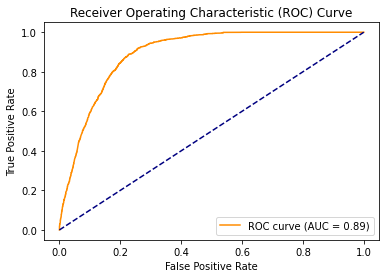

In [119]:
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [120]:
# create inference data set from product catalog cross join to test transactions
inferrence_df = pd.merge(left=toy_products_df[['product_title', 'product_gender', 'product_category']].drop_duplicates(), 
                          right=test[['timestamp', 'hash_customer', 'referrer_source', 'product_title_gender', 'transaction_num']].drop_duplicates(), 
                          how='cross')

inferrence_df.shape

(361375, 8)

In [121]:
test_hist_df = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime(split_date))]

In [122]:
# add user features
user_features_df = calc_user_features(df=test_hist_df)
inferrence_df = pd.merge(left=inferrence_df, 
                        right=user_features_df,
                        left_on='hash_customer',
                        right_on='hash_customer', 
                        how='left')

In [123]:
# add titgen features
titgen_features_df = calc_titgen_features(df=test_hist_df)
inferrence_df = pd.merge(left=inferrence_df, 
                        right=titgen_features_df,
                        left_on='product_title_gender',
                        right_on='product_title_gender', 
                        how='left')

In [124]:
# add user-gen features
user_gen_features_df = calc_user_gen_features(df=test_hist_df)
inferrence_df = pd.merge(left=inferrence_df, 
                        right=user_gen_features_df,
                        left_on=['hash_customer', 'product_gender'],
                        right_on=['hash_customer', 'product_gender'], 
                        how='left')

In [125]:
# add title features
title_features_df = calc_title_features(df=test_hist_df)
inferrence_df = pd.merge(left=inferrence_df, 
                        right=title_features_df,
                        left_on='product_title',
                        right_on='product_title', 
                        how='left')

In [126]:
# add user-cat features
user_cat_features_df = calc_user_cat_features(df=test_hist_df)
inferrence_df = pd.merge(left=inferrence_df, 
                    right=user_cat_features_df,
                    left_on=['hash_customer', 'product_category'],
                    right_on=['hash_customer', 'product_category'], 
                    how='left')

In [127]:
# add cat features
cat_features_df = calc_category_features(as_of_dt=split_date)
inferrence_df = pd.merge(left=inferrence_df, 
                    right=cat_features_df,
                    left_on='product_category',
                    right_on='product_category', 
                    how='left')

In [128]:
# gender
gen_features_df = calc_gen_features(as_of_dt=dt)
inferrence_df = pd.merge(left=inferrence_df, 
                        right=gen_features_df,
                        left_on='product_gender',
                        right_on='product_gender', 
                        how='left')

In [129]:
inferrence_df.shape

(361375, 27)

In [130]:
inferrence_df[fill_na_fields] = inferrence_df[fill_na_fields].fillna(0)

In [131]:
scaled_test_df = scaler.transform(inferrence_df[title_gender_model_fields])

In [132]:
test_preds = title_gender_lr_model.predict_proba(scaled_test_df)

In [133]:
test_preds[:,1]

array([0.00327784, 0.00457377, 0.00505446, ..., 0.55715956, 0.84530023,
       0.75621858])

In [134]:
len(test_preds)

361375

In [135]:
inferrence_df['pred'] = test_preds[:,1]

In [136]:
inferrence_df['pred_rank'] = inferrence_df.groupby(['hash_customer','timestamp'])['pred'].rank(method='first', ascending=False)

In [137]:
sorted_df = inferrence_df.sort_values(['hash_customer', 'timestamp', 'pred'], 
                                       ascending=[True, True, False])
top10_preds_df = sorted_df.groupby(['hash_customer', 'timestamp']).head(10)
top10_preds_df.shape

(24340, 29)

In [138]:
top10_preds_df['product_category'].value_counts()

Sandal     12150
Running     7192
Boot        3082
Sneaker     1916
Name: product_category, dtype: int64

In [139]:
test.head()

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_med_age,zip_male_female_ratio,zip_tot_pop,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,transaction_num,product_title_gender
99,148,2022-06-11 20:00:00,16924928935687922810,16884786084583649830,111.0,Olympic Running,Yellow-Green,Youth,Running,1.5,...,34.6,98.7,39355.0,12850.0,119397.0,148191.0,71.6,4.2,23.0,Olympic Running-Youth
100,149,2022-06-11 20:00:00,16924928935687922810,16884786084583649830,111.0,Olympic Running,Burnt Sienna,Youth,Running,1.5,...,34.6,98.7,39355.0,12850.0,119397.0,148191.0,71.6,4.2,23.0,Olympic Running-Youth
101,150,2022-06-11 20:00:00,16924928935687922810,16884786084583649830,224.0,League Running,Mordant Red 19,Men,Running,11.5,...,34.6,98.7,39355.0,12850.0,119397.0,148191.0,71.6,4.2,23.0,League Running-Men
102,151,2022-06-11 20:00:00,16924928935687922810,16884786084583649830,224.0,Olympic Running,Selective Yellow,Women,Running,11.0,...,34.6,98.7,39355.0,12850.0,119397.0,148191.0,71.6,4.2,23.0,Olympic Running-Women
103,152,2022-06-11 20:00:00,16924928935687922810,16884786084583649830,224.0,Olympic Running,Green (Munsell),Men,Running,11.5,...,34.6,98.7,39355.0,12850.0,119397.0,148191.0,71.6,4.2,23.0,Olympic Running-Men


In [140]:
# Join the recommended item predictions to the test data set on the transaction date
test_eval_df = pd.merge(left=test, 
                   right=top10_preds_df[['hash_customer', 'timestamp', 'product_title', 'product_gender', 'pred_rank']], 
                   left_on=['hash_customer', 'timestamp', 'product_title','product_gender'],
                   right_on=['hash_customer', 'timestamp', 'product_title', 'product_gender'],
                   how='left')

In [141]:
test_eval_df.shape

(3523, 26)

In [142]:
test.shape

(3432, 25)

In [143]:
print_eval_metrics(eval_df=test_eval_df)

Percent of purchases ranked in top 10: 37.0%
Average rank of purchases: 5.69
Mean Reciprocal Rank: 0.212


In [144]:
calc_category_eval_metrics(eval_df=test_eval_df, 
                            category_var = 'product_category')

,product_category,num_purchases,pct_purchases_top10,avg_rank,mrr
0,Running,2136,44.0,5.45,0.222536
1,Sandal,383,25.0,6.52,0.161394
2,Boot,643,17.0,8.59,0.117174
3,Sneaker,361,39.0,4.46,0.248804


In [145]:
calc_category_eval_metrics(eval_df=test_eval_df, 
                            category_var = 'product_gender')

,product_gender,num_purchases,pct_purchases_top10,avg_rank,mrr
0,Youth,147,22.0,6.56,0.165972
1,Men,1007,31.0,5.73,0.210482
2,Women,2098,44.0,5.64,0.214573
3,Kids,154,5.0,7.50,0.150000
4,Unisex,117,19.0,5.14,0.210227


In [146]:
test_eval_df.loc[:,'trans_num_grp'] = np.where(test_eval_df['transaction_num']==1,'purch1', 
                                               np.where(test_eval_df['transaction_num']==2,'purch2', 
                                               np.where(test_eval_df['transaction_num']==3,'purch3', 
                                                        'purch4up')))

In [147]:
calc_category_eval_metrics(eval_df=test_eval_df, 
                            category_var = 'trans_num_grp')

,trans_num_grp,num_purchases,pct_purchases_top10,avg_rank,mrr
0,purch4up,1396,45.0,5.84,0.209495
1,purch2,988,42.0,5.52,0.215449
2,purch3,574,44.0,5.60,0.211983
3,purch1,565,0.0,NaN,NaN


In [ ]:
test_preds_eval_df.head()

In [ ]:
full_test_eval[full_test_eval['hash_customer']==6606248094173010] \
    .groupby('product_category').agg({
        'pred': ['mean', 'count'],
    })

In [ ]:
full_test_eval[full_test_eval['hash_customer']==6606248094173010].sort_values('pred_rank', ascending=True)

In [ ]:
full_test_eval.columns

In [ ]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

NUM_DATES_TO_LOOP_OVER = 5

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates[0:NUM_DATES_TO_LOOP_OVER]):
    print(index, end=',')
    
    pred_df = get_top10_title_gender_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred', 'gender_pred', 'pred_rank']], 
                       left_on=['product_title','product_gender'],
                       right_on=['title_pred', 'gender_pred'],
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])